In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#written by W.T. Chung

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import csv
import matplotlib.pyplot as plt
import torch.nn as nn
import math

# Helper functions

In [2]:
#helper functions from https://github.com/blastnet/blastnet2_sr_benchmark

#convert csv to dict
def my_read_csv(path):
    with open(path, 'r') as file:
        reader = csv.DictReader(file)
        data = {col: [] for col in reader.fieldnames}
        for row in reader:
            for col in reader.fieldnames:
                data[col].append(row[col])
    return data

#get mean/std for train/val sets
def get_mean_std():
    #evaluated thorugh mean of train data in rho and (u,v,w lumped together)
    my_mean = torch.tensor([0.24,28.0, 28.0, 28.0])
    my_std = torch.tensor([0.068,48.0, 48.0, 48.0])

    return my_mean, my_std

#get mean/std for test sets
def get_mean_std_test():
    #evaluated thorugh mean of train data in rho and (u,v,w lumped together)
    my_mean = torch.tensor([0.24,29.0, 29.0, 29.0])
    my_std = torch.tensor([0.068,48.0, 48.0, 48.0])

    return my_mean, my_std

# get mean/std for paramvar set
def get_mean_std_paramvar():
    #evaluated thorugh mean of train data in rho and (u,v,w lumped together)
    my_mean = torch.tensor([0.23,34.0, 34.0, 34.0])
    my_std = torch.tensor([0.059,55.0, 55.0, 55.0])

    return my_mean, my_std

# get mean/std for forcedhit set
def get_mean_std_forcedhit():
    #evaluated thorugh mean of train data in rho and (u,v,w lumped together)
    my_mean = torch.tensor([11,-0.051, -0.051, -0.051])
    my_std = torch.tensor([4.6,1.4, 1.4, 1.4])

    return my_mean, my_std

#normalize by mean and std
class ScaleTransform(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self,mean,std):
        self.mean = mean[:,None,None,None]
        self.std = std[:,None,None,None]
    def __call__(self, sample):
        return (sample- self.mean)/self.std

#get file from path
#Note: np.memmap cannot be used with Kaggle's read only file system, so we're using np.fromfile which does the same thing but slower
def get_file(idx,train_dict,data_path,mode,upscale):
    hash_id = train_dict['hash'][idx]
    scalars = ['RHO_kgm-3_id','UX_ms-1_id','UY_ms-1_id','UZ_ms-1_id']
    #return a 4channel numpy array of the 4 scalars
    X = []
    for scalar in scalars:
        xpath = data_path+'LR_'+str(upscale)+'x/'+mode+'/'+scalar+hash_id+'.dat'
        X.append(np.fromfile(xpath,dtype=np.float32).reshape(128//upscale,128//upscale,128//upscale))
    X = np.stack(X,axis=0)
    Y = []
    for scalar in scalars:
        ypath = data_path+'HR/'+mode+'/'+scalar+hash_id+'.dat'
        Y.append(np.fromfile(ypath,dtype=np.float32).reshape(128,128,128))
    Y = np.stack(Y,axis=0)
    dx = torch.tensor(np.float32(train_dict['dx [m]'][idx]))
    if train_dict['dy [m]'][idx] != '':
        dy = torch.tensor(np.float32(train_dict['dy [m]'][idx]))
    else:
        dy = dx
    if train_dict['dz [m]'][idx] != '':
        dz = torch.tensor(np.float32(train_dict['dz [m]'][idx]))
    else:
        dz = dx

    return torch.from_numpy(X),torch.from_numpy(Y),dx,dy,dz

#torch dataset object
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, my_dict,path, mode,upscale, transform,target_transform,dx_min):
        self.train_dict = my_dict
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.path = path
        self.upscale = upscale
        self.dx_min = dx_min
    def __len__(self):
        return len(self.train_dict['hash'])

    def __getitem__(self, idx):
        X,Y,dx,dy,dz = get_file(idx,self.train_dict,self.path,self.mode,self.upscale)
        dx = dx/self.dx_min
        dy = dy/self.dx_min
        dz = dz/self.dx_min

        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            Y = self.target_transform(Y)
        
        #manually transfrom with rotations and flips
        if self.mode == 'train':
            X,Y,dx,dy,dz = random_rot90_3D(X,Y,dx,dy,dz)
            X,Y = random_flip_3D(X,Y)
        return X, Y,dx,dy,dz

def get_energy(arr):
    return arr[:,0]*(arr[:,1]**2 * arr[:,2]**2 * arr[:,3]**2)

# Setup

In [3]:
test_meta = '/kaggle/input/blastnet-momentum-3d-sr-dataset/test_data_summary.csv'
forcedhit_meta = '/kaggle/input/blastnet-momentum-3d-sr-dataset/forcedhit_data_summary.csv'
paramvar_meta= '/kaggle/input/blastnet-momentum-3d-sr-dataset/paramvar_data_summary.csv'

dx_min = 3.906250185536919e-06
data_path = '/kaggle/input/blastnet-momentum-3d-sr-dataset/dataset/'
upscale = 8
batch_size = 1
num_workers = 0
num_nodes=1
gpu=1
seed = 42


# DataLoaders

In [4]:
test_mean, test_std = get_mean_std_test()
paramvar_mean, paramvar_std = get_mean_std_paramvar()
forcedhit_mean, forcedhit_std = get_mean_std_forcedhit()

test_dict = my_read_csv(test_meta)
forcedhit_dict = my_read_csv(forcedhit_meta)
paramvar_dict = my_read_csv(paramvar_meta)

test_scale_transform = ScaleTransform(test_mean,test_std)
paramvar_scale_transform = ScaleTransform(paramvar_mean,paramvar_std)
forcedhit_scale_transform = ScaleTransform(forcedhit_mean,forcedhit_std)


test_ds = MyDataset(test_dict,data_path,'test',upscale,test_scale_transform,test_scale_transform,dx_min)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=batch_size,
                        shuffle=False,num_workers=num_workers,pin_memory=True)

forcedhit_ds = MyDataset(forcedhit_dict,data_path,'forcedhit',upscale,forcedhit_scale_transform,forcedhit_scale_transform,dx_min)
forcedhit_loader = torch.utils.data.DataLoader(forcedhit_ds,batch_size=batch_size,
                        shuffle=False,num_workers=num_workers,pin_memory=True)
paramvar_ds = MyDataset(paramvar_dict,data_path,'paramvar',upscale,paramvar_scale_transform,paramvar_scale_transform,dx_min)
paramvar_loader = torch.utils.data.DataLoader(paramvar_ds,batch_size=batch_size,
                        shuffle=False,num_workers=num_workers,pin_memory=True)


# Plot features and labels

Test size:  173
Forced HIT size:  128
Param Var. size:  144
num_workers:  0
X shape:  torch.Size([1, 4, 16, 16, 16])
Y shape:  torch.Size([1, 4, 128, 128, 128])
Effective Batch size:  1


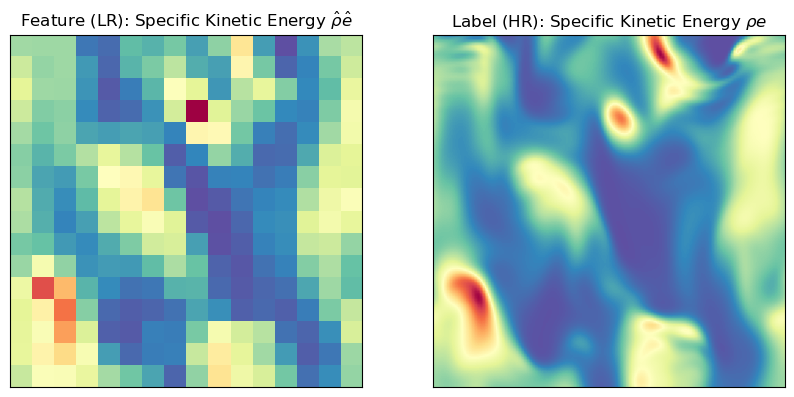

In [5]:
#get output from loader
X0,Y0,_,_,_ = next(iter(paramvar_loader))
print("Test size: ",len(test_ds))
print("Forced HIT size: ",len(forcedhit_ds))
print("Param Var. size: ",len(paramvar_ds))
print("num_workers: ",num_workers)
print("X shape: ",X0.shape)
print("Y shape: ",Y0.shape)
print("Effective Batch size: ",batch_size*num_nodes*gpu)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].imshow(get_energy(X0)[0,:,:,X0.shape[2]//2],cmap='Spectral_r',origin='lower')
axs[0].set_title('Feature (LR): Specific Kinetic Energy $\hat{\\rho} \hat{e}$')
axs[1].set_title('Label (HR): Specific Kinetic Energy $\\rho e$')
axs[1].imshow(get_energy(Y0)[0,:,:,Y0.shape[2]//2],cmap='Spectral_r',origin='lower')

for ax in axs.flatten():
    ax.set_yticks([])
    ax.set_xticks([])

# Model Code

In [6]:
#model code from https://github.com/blastnet/blastnet2_sr_benchmark

def initialize_weights(m,activation,a,scale):
    if isinstance(m, torch.nn.Conv3d):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity=activation,a=a)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, torch.nn.ConvTranspose3d):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity=activation,a=a)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity=activation,a=a)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    else:
        print('no init for ',m)
        pass
    m.weight.data *= scale

class PixelShuffle3d(nn.Module):
    '''
    This class is a 3d version of pixelshuffle.
    '''
    def __init__(self, scale):
        '''
        :param scale: upsample scale
        '''
        super().__init__()
        self.scale = scale

    def forward(self, input):
        batch_size, channels, in_depth, in_height, in_width = input.size()
        nOut = channels // self.scale ** 3

        out_depth = in_depth * self.scale
        out_height = in_height * self.scale
        out_width = in_width * self.scale

        input_view = input.contiguous().view(batch_size, nOut, self.scale, self.scale, self.scale, in_depth, in_height, in_width)

        output = input_view.permute(0, 1, 5, 2, 6, 3, 7, 4).contiguous()

        return output.view(batch_size, nOut, out_depth, out_height, out_width)

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv3d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 8 * n_feat, 3, bias))
                initialize_weights(m[-1], 'relu', None, 0.1)
                m.append(PixelShuffle3d(2))
                if bn: m.append(nn.BatchNorm3d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 27 * n_feat, 3, bias))
            initialize_weights(m[-1], 'relu', None, 0.1)
            m.append(PixelShuffle3d(3))
            if bn: m.append(nn.BatchNorm3d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        # feature channel downscale and upscale --> channel weight
        conv1 = nn.Conv3d(channel, channel // reduction, 1, padding=0, bias=True)
        conv2 = nn.Conv3d(channel // reduction, channel, 1, padding=0, bias=True)
        initialize_weights(conv1, 'relu', None, 0.1)
        initialize_weights(conv2, 'linear', None, 0.1)
        self.conv_du = nn.Sequential(
                conv1,
                nn.ReLU(inplace=True),
                conv2,
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if i ==0: 
                initialize_weights(modules_body[-1], 'relu', None, 0.1)
            else:
                initialize_weights(modules_body[-1], 'linear', None, 0.1)
            if bn: modules_body.append(nn.BatchNorm3d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        conv1 = conv(n_feat, n_feat, kernel_size)
        initialize_weights(conv1, 'linear', None, 0.1)
        modules_body.append(conv1)
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, n_resgroups, n_resblocks, n_feats, reduction, scale, n_colors, res_scale, conv=default_conv):
        super(RCAN, self).__init__()
        
        kernel_size = 3
        act = nn.ReLU(True)
        self.upscale=scale
        # define head module
        conv1 = conv(n_colors, n_feats, kernel_size)
        initialize_weights(conv1, 'linear', None, 0.1)
        modules_head = [conv1]

        # define body module
        #already initialized in 
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]
        conv2 = conv(n_feats, n_feats, kernel_size)
        initialize_weights(conv2, 'linear', None, 0.1)
        modules_body.append(conv2)

        # define tail module
        conv3 = conv(n_feats, n_colors, kernel_size)
        initialize_weights(conv3, 'linear', None, 0.1)
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv3]

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)

        return x 

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))
            

def init_rcan(approx_param,upscale):
    #1b,firstc 16  = 0.888M params, 1 group, 1 block,34 feats
    #1b,firstc 32  = 1.4M params, 1 group, 1 block,44 feats
    #1b = 2.7M params, 1 group, 1 block, 60 feats
    #5b = 11M params 2 group, 20 block,64 feats
    #8b = 16M params 3 group, 20 block
    #16b = 35.1M params 7 group, 20 block
    #23b = 48M params 10 group, 20 block
    if approx_param == '0.5M':
        n_feats = 26
        n_resblocks = 1
        n_resgroups = 1
    elif approx_param == '0.8M':
        n_feats = 34
        n_resblocks = 1
        n_resgroups = 1
    elif approx_param == '1.4M':
        n_feats = 44
        n_resblocks = 1
        n_resgroups = 1
    elif approx_param == '2.7M':
        n_feats = 60
        n_resblocks = 1
        n_resgroups = 1
    elif approx_param == '5M':
        n_feats = 64
        n_resblocks = 10
        n_resgroups = 1
    elif approx_param == '11M':
        n_feats = 64
        n_resblocks = 20
        n_resgroups = 2
    elif approx_param == '17M':
        n_feats = 64
        n_resblocks = 20
        n_resgroups = 3
    elif approx_param == '50M':
        n_feats = 64
        n_resblocks = 20
        n_resgroups = 10
    else:
        raise ValueError('Please provide the correct model_blocks and first_channel')
    return RCAN(n_feats=n_feats,n_colors=4, n_resgroups=n_resgroups,n_resblocks=n_resblocks,reduction=16,scale=upscale,res_scale=1)


# Model Setup

In [7]:
model_dict = my_read_csv('/kaggle/input/blastnet-momentum-3d-sr-dataset/best_model_weights/model_summary.csv')
model_dir = '/kaggle/input/blastnet-momentum-3d-sr-dataset/best_model_weights/seed42/'

model_idx = 0
model_file = model_dict['filename'][model_idx]
approx_params = model_dict['approx_num_params'][model_idx]

print("Reading model:",model_file)
model = init_rcan(approx_params,upscale)
model.load_state_dict(torch.load(model_dir+model_file))


Reading model: rcan_approx0.8M_8xSR.pt


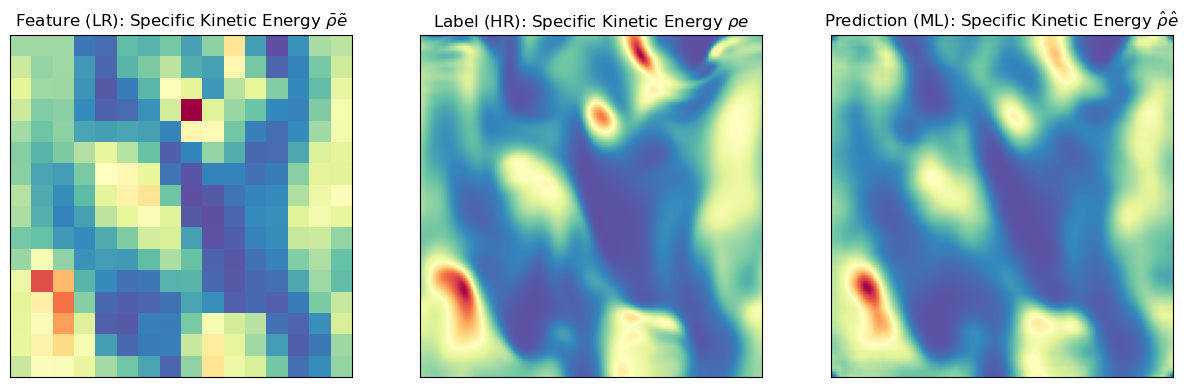

In [8]:
Yhat = model(X0).detach()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs[0].imshow(get_energy(X0)[0,:,:,X0.shape[2]//2],cmap='Spectral_r',origin='lower')
axs[0].set_title('Feature (LR): Specific Kinetic Energy $\\bar{\\rho} \\tilde{e}$')
axs[1].imshow(get_energy(Y0)[0,:,:,Y0.shape[2]//2],cmap='Spectral_r',origin='lower')
axs[1].set_title('Label (HR): Specific Kinetic Energy $\\rho e$')
axs[2].imshow(get_energy(Yhat)[0,:,:,Yhat.shape[2]//2],cmap='Spectral_r',origin='lower')
axs[2].set_title('Prediction (ML): Specific Kinetic Energy $\hat{\\rho} \hat{e}$')


for ax in axs.flatten():
    ax.set_yticks([])
    ax.set_xticks([])